## Relax Data Science Challenge


- The data is available as two attached CSV files: takehome_user_engagement. csv, takehome_users . csv
- The data has the following two tables:
A user table ( "takehome_users" ) with data on 12,000 users who signed up for the product in the last two years. This table includes:
- name: the user's name
- object_id: the user's id
- email: email address
- creation_source: how their account was created. This takes on one of 5 values:
- PERSONAL_PROJECTS: invited to join another user's personal workspace
- GUEST_INVITE: invited to an organization as a guest (limited permissions)
- ORG_INVITE: invited to an organization (as a full member)
- SIGNUP: signed up via the website
- SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
- creation_time: when they created their account
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving marketing emails
- enabled_for_marketing_drip: whether they are on the regular marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).


A usage summary table ( "takehome_user_engagement A usage summary table ( "takehome_user_engagement" ) that has a row for each day that a user logged into the product.
Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday
period , identify which factors predict future user adoption .
We suggest spending 12 hours on this, but you're welcome to spend more or less.
Please send us a brief writeup of your findings (the more concise, the better no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from collections import Counter
%matplotlib inline
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
from sklearn.metrics import log_loss
from sklearn.metrics import average_precision_score
from sklearn.neural_network import MLPClassifier
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import string

In [2]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv')
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
users_df = pd.read_csv('takehome_users.csv', encoding='latin-1')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Examin the user data to see who is actually using the application

In [6]:
print('There are {} users who have ever used the application.'\
          .format(user_engagement_df['user_id'].nunique()))
print('There are {} signed up for the application.'\
          .format(users_df['object_id'].nunique()))

There are 8823 users who have ever used the application.
There are 12000 signed up for the application.


In [7]:
# how many people never signed in?
print('There are ', len(users_df[users_df['last_session_creation_time'].isnull()]), 'inactive users.')

There are  3177 inactive users.


We have two data sets. I can use the first dataset to determine if a user is "adopted" ro the app. Then with the second data set I can produce and evaluate a predictive model. As part of this process we will have to deal with any missing, duplicate, and/or irrelevant data points.

As outlined, in this case an adopted user is any ID that had logged in on at least 3 serarate occasions in a 7 day period.

## Find the adopted users

In [8]:
user_engagement_df['time_stamp'] = pd.to_datetime(user_engagement_df['time_stamp'])
# How many values does 'visited' take?
user_engagement_df['visited'].unique()

array([1], dtype=int64)

In [9]:
ses_stats = pd.Series([])
days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
for day in days:
    k = user_engagement_df.groupby(['user_id', pd.Grouper(key='time_stamp', freq='W-' + day)])['visited'].count().reset_index().sort_values('user_id')
    k = k.groupby('user_id')['visited'].max()
    if len(ses_stats) == 0:
        ses_stats = k
    else:
        ses_stats = pd.DataFrame([ses_stats, k]).max()
users_df['adopted_user'] = users_df['object_id'].apply(lambda x: 1 if x in ses_stats and ses_stats[x] >= 3 else 0)

#### What percentage of the users are adopted?

0    10398
1     1602
Name: adopted_user, dtype: int64


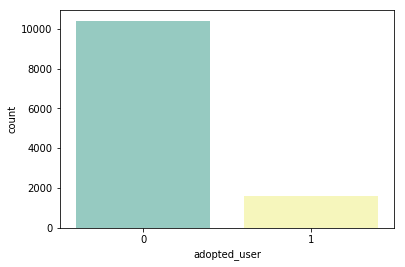

In [10]:
print(users_df['adopted_user'].value_counts())
sns.countplot(users_df['adopted_user'],palette="Set3")
plt.show()

In [11]:
print('Total percentage of the adopted users are:',100*users_df['adopted_user'].sum()/users_df['adopted_user'].count(),'%')

Total percentage of the adopted users are: 13.35 %


### <span style="color:indigo"> Total percentage of the adopted users are: 13.35 %

In [12]:
df=users_df
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


#### Find the major domains of each email id

In [13]:
df['email'] = df['email'].apply(lambda x: x[x.find('@')+1:])
major_domains = ['gmail.com', 'yahoo.com', 'jourrapide.com', 'cuvox.de', 'gustr.com', 'hotmail.com']
df['email'] = df['email'].apply(lambda x: 'other' if x not in major_domains else x[:x.find('.')])

gmail         3562
yahoo         2447
jourrapide    1259
cuvox         1202
other         1186
gustr         1179
hotmail       1165
Name: email, dtype: int64


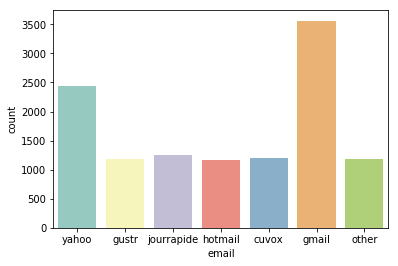

In [14]:
print(df['email'].value_counts())
sns.countplot(df['email'],palette="Set3")
plt.show()

#### Most emails are in gmail domain

#### Create new clumns: The hour, month and the year of the creation account

In [15]:
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['hour'] = df['creation_time'].apply(lambda x: x.hour)
df['month'] = df['creation_time'].apply(lambda x: x.month)
df['year'] = df['creation_time'].apply(lambda x: x.year)

Fill the NaN valus and drop the unnecessary columns

In [16]:
df['last_session_creation_time'] = df['last_session_creation_time'].fillna(df['last_session_creation_time'].mean())
df.drop(['name', 'creation_time','invited_by_user_id'], axis=1, inplace=True)

#### Change columns with string values to integers

In [17]:
df.email = pd.Categorical(df.email)
df['email'] = df.email.cat.codes

df.creation_source = pd.Categorical(df.creation_source)
df['creation_source'] = df.creation_source.cat.codes

df.head()

,object_id,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,hour,month,year
0,1,6,0,1.398139e+09,1,0,11,0,3,4,2014
1,2,2,1,1.396238e+09,0,0,1,1,3,11,2013
2,3,2,1,1.363735e+09,0,0,94,0,23,3,2013
3,4,6,0,1.369210e+09,0,0,1,0,8,5,2013
4,5,6,0,1.358850e+09,0,0,193,0,10,1,2013


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
email                         12000 non-null int8
creation_source               12000 non-null int8
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
adopted_user                  12000 non-null int64
hour                          12000 non-null int64
month                         12000 non-null int64
year                          12000 non-null int64
dtypes: float64(1), int64(8), int8(2)
memory usage: 867.3 KB


## Classification

In [19]:
X = df.drop('adopted_user', axis=1)
y = df['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=0)

## Predictive Models

In [20]:
models = []
models.append(('KNN', KNeighborsClassifier()))
#models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('AB',AdaBoostClassifier()))
models

[('KNN',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform')),
 ('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False)),
 ('DT',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 ('GNB', GaussianNB(priors=None, var_smoothing=1e-09)),
 ('RF',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_de

In [21]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

names = []
scores = []
AUC=[]
Log_loss=[]
for name, model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    scores.append(accuracy_score(y_test, y_pred))
    AUC.append(roc_auc)
    names.append(name)
    Log_loss.append(round(log_loss(y_test, y_pred),4))
tr_split = pd.DataFrame({'Name': names, 'Accuracy': scores,'AUC':AUC,'Log_loss':Log_loss})
print(tr_split)

100%|██████████| 7/7 [00:01<00:00,  2.52it/s]


  Name  Accuracy       AUC  Log_loss
0  KNN  0.919167  0.861302    2.7919
1   LR  0.868611  0.126442    4.5380
2   DT  0.959167  0.906515    1.4103
3  GNB  0.868611  0.872892    4.5380
4   RF  0.962222  0.952922    1.3048
5   GB  0.966389  0.980527    1.1609
6   AB  0.959722  0.970501    1.3911


In [22]:
SVC().fit(X_train, y_train)
y_pred = model.predict(X_test)
log_loss(y_test, y_pred)
print('SVC log_loss:',log_loss(y_test, y_pred))

SVC log_loss: 1.3911484920065291


### AUC and log loss score with cross validation

In [24]:
names = []
scores = []
for name, model in tqdm(models):
    kfold = KFold(n_splits=10, random_state=10) 
    score = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc').mean()
    names.append(name)
    scores.append(score)
kf_cross_val = pd.DataFrame({'Name': names, 'AUC score': scores})
print(kf_cross_val)

100%|██████████| 7/7 [00:16<00:00,  3.58s/it]


  Name  AUC score
0  KNN   0.854175
1   LR   0.129286
2   DT   0.906477
3  GNB   0.870445
4   RF   0.954608
5   GB   0.982100
6   AB   0.968742


### Visualize AUC scores

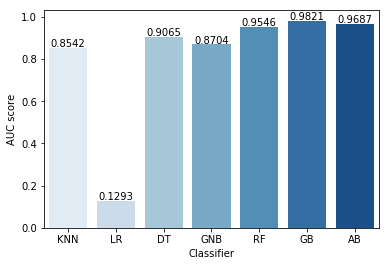

In [25]:
axis = sns.barplot(x = 'Name', y = 'AUC score', data = kf_cross_val, palette='Blues')
axis.set(xlabel='Classifier', ylabel='AUC score')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

#### The best classifier is the Gradientboosting. In next section I check the feature importane and tune the hyperparameters to get the best result out of it.

In [26]:
clf = GradientBoostingClassifier(verbose=True)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           0.6616            1.39s
         2           0.5943            1.42s
         3           0.5467            1.32s
         4           0.5091            1.27s
         5           0.4793            1.23s
         6           0.4541            1.21s
         7           0.4291            1.18s
         8           0.4104            1.17s
         9           0.3951            1.18s
        10           0.3817            1.18s
        20           0.3053            0.87s
        30           0.2720            0.75s
        40           0.2455            0.62s
        50           0.2155            0.49s
        60           0.1959            0.38s
        70           0.1825            0.28s
        80           0.1699            0.19s
        90           0.1602            0.09s
       100           0.1511            0.00s
Train Score: 0.973
Test Score: 0.966


In [27]:
# TP / FP 
confusion_matrix(y_test, clf.predict(X_test))

array([[3106,   21],
       [ 100,  373]], dtype=int64)

#### Examine the model feature importance.

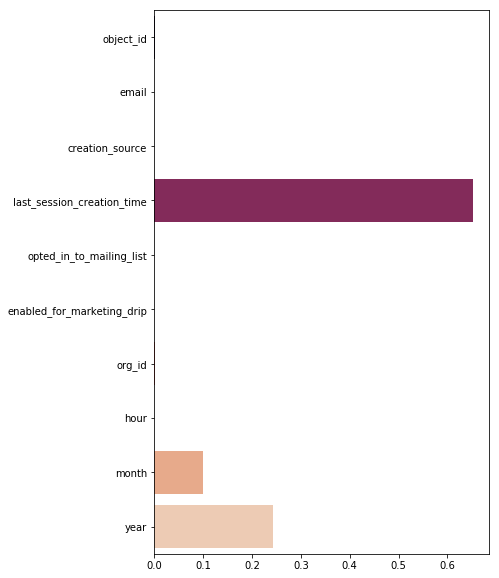

In [28]:
features = pd.Series(clf.feature_importances_, index=X.columns)
plt.figure(figsize=(6,10))
sns.barplot(y=X.columns, x=clf.feature_importances_, palette='rocket')
plt.show()

In [29]:
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,0.652020
year,0.243283
month,0.099677
org_id,0.001805
object_id,0.001706
creation_source,0.000785
email,0.000425
hour,0.000299
opted_in_to_mailing_list,0.000000
enabled_for_marketing_drip,0.000000


### <span style="color:indigo"> The most important feature is the 'last_session_creation_time'.

#### Hyperparmeter tuning

In [32]:
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                                min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=0), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_sa...      subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [33]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 80}, 0.9772863447068101)

In [34]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}

gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                                               n_estimators=80, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=0), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 7, 'min_samples_split': 400}, 0.978600236011068)

In [35]:
clf_tuned = GradientBoostingClassifier(learning_rate=0.1, 
                                       n_estimators=80, 
                                       max_features='auto', 
                                       subsample=0.8,
                                       max_depth= 7,
                                       min_samples_split= 400,
                                       random_state=0,
                                       verbose=True)

In [36]:
clf_tuned.fit(X_train,y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6553           0.1284            1.42s
         2           0.5810           0.0662            1.48s
         3           0.5248           0.0549            1.46s
         4           0.4773           0.0376            1.46s
         5           0.4452           0.0345            1.53s
         6           0.4098           0.0292            1.55s
         7           0.3841           0.0284            1.54s
         8           0.3657           0.0180            1.49s
         9           0.3422           0.0207            1.49s
        10           0.3245           0.0165            1.48s
        20           0.2203           0.0048            1.16s
        30           0.1757           0.0041            0.91s
        40           0.1551           0.0002            0.72s
        50           0.1266           0.0001            0.53s
        60           0.1101          -0.0003            0.35s
       

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=400,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [37]:
score = cross_val_score(clf_tuned, X, y, cv=kfold, scoring='roc_auc').mean()

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6571           0.1253            2.05s
         2           0.5775           0.0767            2.34s
         3           0.5288           0.0454            2.31s
         4           0.4817           0.0406            2.32s
         5           0.4469           0.0310            2.28s
         6           0.4098           0.0332            2.29s
         7           0.3900           0.0280            2.26s
         8           0.3656           0.0198            2.24s
         9           0.3442           0.0216            2.29s
        10           0.3205           0.0216            2.37s
        20           0.2215           0.0058            1.77s
        30           0.1706           0.0008            1.35s
        40           0.1485           0.0030            1.04s
        50           0.1330           0.0003            0.75s
        60           0.1151           0.0000            0.51s
       

         6           0.4038           0.0349            2.40s
         7           0.3745           0.0250            2.38s
         8           0.3544           0.0220            2.37s
         9           0.3350           0.0167            2.31s
        10           0.3181           0.0154            2.27s
        20           0.2193           0.0076            1.63s
        30           0.1718           0.0013            1.28s
        40           0.1532           0.0011            0.96s
        50           0.1343           0.0004            0.70s
        60           0.1188          -0.0002            0.47s
        70           0.1029           0.0002            0.23s
        80           0.0988          -0.0001            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6407           0.1273            2.53s
         2           0.5685           0.0726            2.57s
         3           0.5128           0.0495            2.51s
       

In [38]:
print('Tuned Gradientboosting AUC score:',score)

Tuned Gradientboosting AUC score: 0.9839119976290194


### Classification over the balance target dataset:

#### Since the dataset is unbalanced, I use SMOTE oversampling to balance out the classes

[(0, 10398), (1, 10398)]


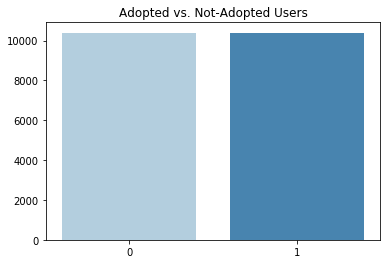

In [39]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled =SMOTE().fit_sample(X, y)
print(sorted(Counter(y_resampled).items()))

sns.countplot(y_resampled, palette='Blues')
plt.ylabel('')
plt.title('Adopted vs. Not-Adopted Users');

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size=0.30, random_state=0)

In [41]:
models = []
models.append(('KNN', KNeighborsClassifier()))
#models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('AB',AdaBoostClassifier()))
models

[('KNN',
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=None, n_neighbors=5, p=2,
             weights='uniform')),
 ('LR',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False)),
 ('DT',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 ('GNB', GaussianNB(priors=None, var_smoothing=1e-09)),
 ('RF',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_de

In [42]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

names = []
scores = []
AUC=[]
Log_loss=[]
for name, model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds=roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    scores.append(accuracy_score(y_test, y_pred))
    AUC.append(roc_auc)
    names.append(name)
    Log_loss.append(round(log_loss(y_test, y_pred),4))
tr_split = pd.DataFrame({'Name': names, 'Accuracy': scores,'AUC':AUC,'Log_loss':Log_loss})
print(tr_split)

100%|██████████| 7/7 [00:03<00:00,  1.38it/s]


  Name  Accuracy       AUC  Log_loss
0  KNN  0.839558  0.907956    5.5415
1   LR  0.500721  0.863215   17.2449
2   DT  0.973393  0.973393    0.9190
3  GNB  0.789389  0.856321    7.2743
4   RF  0.972592  0.995427    0.9467
5   GB  0.972431  0.996313    0.9522
6   AB  0.954961  0.990451    1.5556


#### Since the dataset is balanced, the correct accuracy could be correct metric for evalution as well. Like previous section, the best result is from Gradient boosting classifier.

In [43]:
clf = GradientBoostingClassifier(verbose=True)
clf.fit(X_train, y_train)
print('Train Score:', round(clf.score(X_train,y_train),3))
print('Test Score:', round(clf.score(X_test,y_test),3))

      Iter       Train Loss   Remaining Time 
         1           1.2536            2.77s
         2           1.1450            3.04s
         3           1.0527            3.07s
         4           0.9755            3.12s
         5           0.9132            3.04s
         6           0.8621            2.90s
         7           0.8121            2.74s
         8           0.7717            2.63s
         9           0.7310            2.54s
        10           0.6970            2.46s
        20           0.4937            2.01s
        30           0.3881            1.56s
        40           0.3248            1.25s
        50           0.2798            1.05s
        60           0.2426            0.85s
        70           0.2157            0.63s
        80           0.1902            0.41s
        90           0.1699            0.21s
       100           0.1568            0.00s
Train Score: 0.978
Test Score: 0.972


In [44]:
# Find feature importances
features = pd.Series(clf.feature_importances_, index=X.columns)
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
last_session_creation_time,0.716593
year,0.144621
month,0.074251
opted_in_to_mailing_list,0.021234
email,0.021104
creation_source,0.010965
org_id,0.006897
enabled_for_marketing_drip,0.003502
hour,0.000547
object_id,0.000286


### Conclusion:
- <span style="color:indigo">About 13.35 % of the userbase are the adopted users.This clearly indicates that there is a lot that can be done to decrease this proportion relative to the number of adopted users.
- <span style="color:indigo">last_session_creation_time** is the most important feature when it comes to predicting adopted users. It accounts for more than 65% of the importance in our Gradient Boosting Classifier.
- <span style="color:indigo">Year and Month** of account created is the next most important information. However, its importance is negligible compared to last login time.
- <span style="color:indigo">All the other features have close to zero importance and do not explain the target variable well. 
- <span style="color:indigo">My recommendations at this point would be to identify the top sources of engaged users (sign-up origin) and increase marketing efforts there. Further, we can conduct more detailed surveys amoungst adopted users to attempt to identify new common features to add to the model that may increase its validity. 